In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from xgboost import DMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder as le

In [75]:
data = pd.read_csv('payment-practices.csv')

In [76]:
data['End date'] = pd.to_datetime(data['End date'], format='mixed')
data = data[data['End date'].dt.year<2020][:24000]

In [77]:
data.shape

(24000, 23)

In [78]:
data.columns

Index(['Report Id', 'Start date', 'End date', 'Filing date', 'Company',
       'Company number', 'Payments made in the reporting period',
       'Average time to pay', '% Invoices paid within 30 days',
       '% Invoices paid between 31 and 60 days',
       '% Invoices paid later than 60 days',
       '% Invoices not paid within agreed terms',
       'Shortest (or only) standard payment period',
       'Longest standard payment period', 'Maximum contractual payment period',
       'Payment terms have changed', 'Suppliers notified of changes',
       'Participates in payment codes', 'E-Invoicing offered',
       'Supply-chain financing offered',
       'Policy covers charges for remaining on supplier list',
       'Charges have been made for remaining on supplier list', 'URL'],
      dtype='object')

In [79]:
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

80th Quantile =  51.0


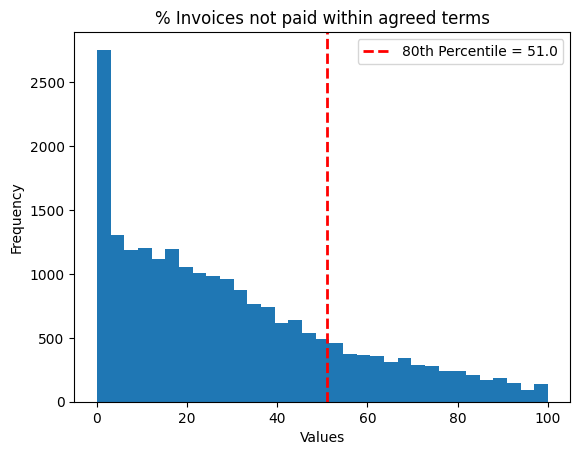

In [80]:
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

plt.hist(data['% Invoices not paid within agreed terms'],bins=33)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

In [81]:
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,10337,43.070833
Average time to pay,2414,10.058333
% Invoices paid within 30 days,2414,10.058333
% Invoices paid between 31 and 60 days,2414,10.058333
% Invoices paid later than 60 days,2414,10.058333
% Invoices not paid within agreed terms,2372,9.883333
Shortest (or only) standard payment period,2372,9.883333
Longest standard payment period,9832,40.966667
Maximum contractual payment period,2372,9.883333
Payment terms have changed,2372,9.883333


In [82]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [83]:
# Imputing the Continuous missing values with Mean
for var in numerical_features:
    data.fillna({var:data[var].mean()}, inplace=True)

In [84]:
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,10337,43.070833
Average time to pay,0,0.000000
% Invoices paid within 30 days,0,0.000000
% Invoices paid between 31 and 60 days,0,0.000000
% Invoices paid later than 60 days,0,0.000000
% Invoices not paid within agreed terms,0,0.000000
Shortest (or only) standard payment period,0,0.000000
Longest standard payment period,0,0.000000
Maximum contractual payment period,0,0.000000
Payment terms have changed,2372,9.883333


In [85]:
from sklearn.impute import KNNImputer

# Create an instance of KNNImputer
imputer = KNNImputer()

# Impute the missing values in the columns specified in missing_data_cols
data_imputed = imputer.fit_transform(data)

# Convert the imputed data back to a DataFrame
data_imputed = pd.DataFrame(data_imputed,columns=data.columns)


In [86]:
data = data_imputed

In [87]:
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


In [88]:
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

In [89]:
new_order=[     'flag',
                'Payments made in the reporting period', 'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payment terms have changed', 'Suppliers notified of changes',
                'Participates in payment codes', 'E-Invoicing offered',
                'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']

<Axes: >

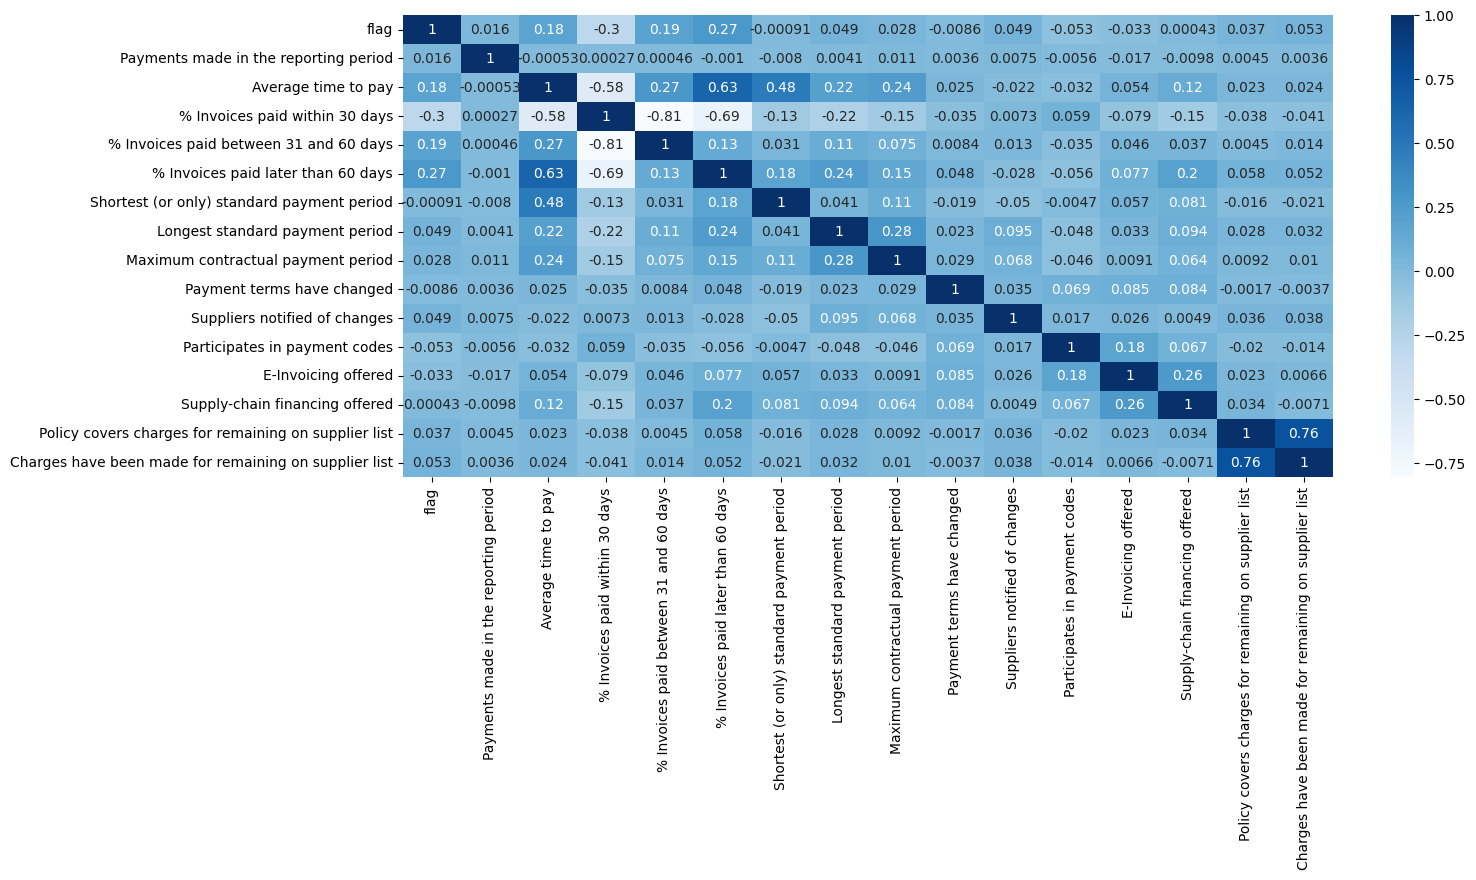

In [90]:
# Correlation Analysis
plt.figure(figsize=(15, 6))
sns.heatmap(data.reindex(columns=new_order).corr(),annot=True,cmap='Blues')

In [91]:
# Dropping the Highly correlated Features
data1 = data.drop(columns=[ '% Invoices paid within 30 days', 
                            '% Invoices paid later than 60 days',
                            'Suppliers notified of changes',
                            'Policy covers charges for remaining on supplier list'])

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data1.drop(columns=['flag']), data1['flag'], test_size=0.3, random_state=42)

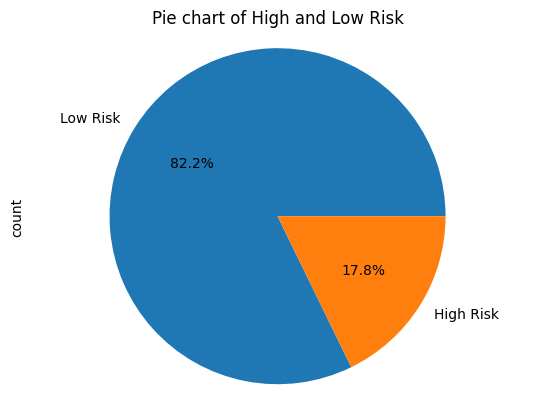

In [101]:
y_train.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk')
plt.show()


In [102]:
from imblearn.over_sampling import RandomOverSampler

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler()

# Perform random oversampling on X_train and y_train
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)


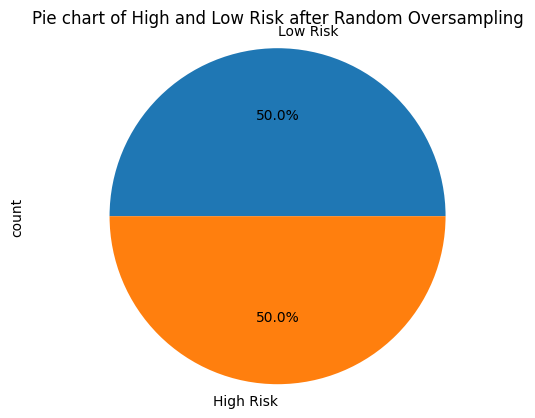

In [103]:
y_train_oversampled.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk after Random Oversampling')
plt.show()

Implementing XGBoost model

In [104]:
from sklearn.metrics import f1_score, roc_auc_score
from xgboost import XGBClassifier

params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_train_oversampled, y_train_oversampled)

y_pred = xgb_clf.predict(X_test)

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC:', auc)

XGBoost model accuracy score: 0.7906
F1 Score: 0.5248897290485193
AUC: 0.746610878661088


Implementing Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Fit the model to the data
model.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the data
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

print("Random Forest Accuracy:", accuracy)

f1 = f1_score(y_test, predictions)
print('F1 Score:', f1)

# Calculate AUC
auc = roc_auc_score(y_test, predictions)
print('AUC:', auc)

Random Forest Accuracy: 0.8397222222222223
F1 Score: 0.5122569737954353
AUC: 0.7025770642985227


Implementing Gradient Boost Decision Tree

In [107]:
from sklearn.ensemble import GradientBoostingClassifier

# Create an instance of the GradientBoostingClassifier
gbdt_clf = GradientBoostingClassifier()

# Fit the model to the data
gbdt_clf.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the test data
y_pred_gbdt = gbdt_clf.predict(X_test)

# Calculate accuracy
accuracy_gbdt = accuracy_score(y_test, y_pred_gbdt)
print("Gradient Boosting Decision Tree Accuracy:", accuracy_gbdt)

# Calculate F1 score
f1_gbdt = f1_score(y_test, y_pred_gbdt)
print("F1 Score:", f1_gbdt)

# Calculate AUC
auc_gbdt = roc_auc_score(y_test, y_pred_gbdt)
print("AUC:", auc_gbdt)


Gradient Boosting Decision Tree Accuracy: 0.6884722222222223
F1 Score: 0.46120586115781886
AUC: 0.7263137221415763


Implementing Light GM

In [109]:
import lightgbm as lgb

# Create an instance of the LightGBM classifier
lgb_clf = lgb.LGBMClassifier()

# Fit the model to the oversampled training data
lgb_clf.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the test data
y_pred_lgb = lgb_clf.predict(X_test)

# Calculate accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("LightGBM Accuracy:", accuracy_lgb)

# Calculate F1 score
f1_lgb = f1_score(y_test, y_pred_lgb)
print("F1 Score:", f1_lgb)

# Calculate AUC
auc_lgb = roc_auc_score(y_test, y_pred_lgb)
print("AUC:", auc_lgb)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13814, number of negative: 13814
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 27628, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.7429166666666667
F1 Score: 0.5041521564425395
AUC: 0.7529519255400905
